## Задание 1

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from transformers import BertTokenizer, BertModel, AdamW, BertConfig, RobertaTokenizer, RobertaModel, RobertaConfig, Adafactor
from torch.nn import functional as F
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

In [2]:
data = pd.read_csv('lenta_40k.csv')

In [3]:
data['topic'].value_counts()

Россия               9622
Мир                  8193
Экономика            4768
Спорт                3894
Наука и техника      3204
Культура             3183
Бывший СССР          3182
Интернет и СМИ       2643
Из жизни             1679
Дом                  1315
Силовые структуры    1203
Ценности              460
Бизнес                433
Путешествия           418
69-я параллель         82
Крым                   43
Культпросвет           25
Легпром                 6
Библиотека              3
Name: topic, dtype: int64

In [4]:
data = data[~data['topic'].isin(['69-я параллель', 'Крым', 'Культпросвет ', 'Легпром', 'Библиотека'])]

In [5]:
data['topic'].value_counts()

Россия               9622
Мир                  8193
Экономика            4768
Спорт                3894
Наука и техника      3204
Культура             3183
Бывший СССР          3182
Интернет и СМИ       2643
Из жизни             1679
Дом                  1315
Силовые структуры    1203
Ценности              460
Бизнес                433
Путешествия           418
Name: topic, dtype: int64

In [6]:
device = torch.device("cuda:6" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=6)

In [7]:
label2id = {label: i for i, label in enumerate(data['topic'].unique())}

In [23]:
label2id

{'Спорт': 0,
 'Мир': 1,
 'Интернет и СМИ': 2,
 'Россия': 3,
 'Наука и техника': 4,
 'Силовые структуры': 5,
 'Бывший СССР': 6,
 'Культура': 7,
 'Экономика': 8,
 'Ценности': 9,
 'Из жизни': 10,
 'Дом': 11,
 'Бизнес': 12,
 'Путешествия': 13}

In [24]:
data['text'] = data['text'].apply(lambda x: x[:512])
data['topic'] = data['topic'].map(label2id)

In [63]:
data['topic'].value_counts()

3     9622
1     8193
8     4768
0     3894
4     3204
7     3183
6     3182
2     2643
10    1679
11    1315
5     1203
9      460
12     433
13     418
Name: topic, dtype: int64

In [64]:
data['text'] = data['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [10]:
train, val = train_test_split(data, test_size=0.15, stratify=data['topic'], shuffle=True)

In [11]:
train.shape, val.shape

((37567, 2), (6630, 2))

In [12]:
x_train, y_train = train['text'], train['topic']
x_val, y_val = val['text'], val['topic']

In [27]:
y_train = y_train.map(label2id)
y_val = y_val.map(label2id)

Первую модель возьмем DeepPavlov/rubert-base-cased:

In [28]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [29]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_train)]
val_tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_val)]

  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

In [30]:
train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts)]

train_inputs = pad_sequences(train_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

train_masks = [[float(i>0) for i in seq] for seq in train_inputs]

validation_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(val_tokenized_texts)]

validation_inputs = pad_sequences(validation_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]

train_labels, validation_labels = np.array(y_train), np.array(y_val)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=8,
    sampler=torch.utils.data.RandomSampler(train_data)
)

validation_data = torch.utils.data.TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=8,
    sampler=torch.utils.data.SequentialSampler(validation_data)
)

  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

In [31]:
num_labels = data['topic'].nunique()

Класс модели:

In [32]:
class myBertModel(torch.nn.Module):
    def __init__(self, hidden_neurons, num_labels):
        super(myBertModel, self).__init__()
        self.num_labels = num_labels
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=self.num_labels)
        self.model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased', config=config)
        self.hidden_neurons = hidden_neurons
        self.linear1 = torch.nn.Linear(config.hidden_size, self.hidden_neurons)
        self.linear2 = torch.nn.Linear(self.hidden_neurons, int(self.hidden_neurons / 2))
        self.classifier = torch.nn.Linear(int(self.hidden_neurons / 2), self.num_labels)
        self.activation = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(.3)
        self.batchnorm1 = torch.nn.BatchNorm1d(self.hidden_neurons)
        self.batchnorm2 = torch.nn.BatchNorm1d(int(self.hidden_neurons / 2))

    def forward(self, input_ids, attention_mask):
        bert_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = bert_output[0]
        pooled_output = seq_output.mean(axis=1)
        pooled_output = self.dropout(pooled_output)
        
        x1 = self.dropout(F.relu(self.batchnorm1(self.linear1(pooled_output))))
        x1 = self.dropout(F.relu(self.batchnorm2(self.linear2(x1))))
        
        scores = self.dropout(self.classifier(x1))
        scores = self.activation(scores)
        return scores

my_model = myBertModel(hidden_neurons=512, num_labels=num_labels)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
def train_bert(model, n_model, n_epochs, train_dataloader, validation_dataloader, lr):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    loss = torch.nn.CrossEntropyLoss()
#     loss = torch.nn.BCEWithLogitsLoss()
    loss_set = []
    val_loss_set = []

    for epoch in range(n_epochs):
          epoch_loss_set = []

          model.train()

          for j, batch in enumerate(tqdm(train_dataloader)):
              
              batch = tuple(t.to(device) for t in batch)
              b_input_ids, b_input_mask, b_labels = batch
              
              optimizer.zero_grad()
              
              pred_probs = model.forward(b_input_ids, b_input_mask)

#               b_labels = b_labels.float().reshape(-1, 1) # удалить при смене лосса

              my_loss = loss(pred_probs, b_labels)
              epoch_loss_set.append(my_loss.item())
              my_loss.backward()
              
              pred_probs = torch.nn.Sigmoid()(pred_probs)
              pred_probs = pred_probs.detach().to('cpu').numpy()
              pred_labels = pred_probs.argmax(axis=1) # восстановить при смене
#               pred_labels = np.where(pred_probs > 0.5, 1, 0)
              b_labels = b_labels.to('cpu').numpy()
                  
              optimizer.step()
                  
              if j == 0:
                  all_train_labels = b_labels
                  all_train_preds = pred_labels
              else:
                  all_train_labels = np.hstack([all_train_labels, b_labels])
                  all_train_preds = np.hstack([all_train_preds, pred_labels])
                          
          loss_set.extend(epoch_loss_set)
          
          train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
          print(classification_report(all_train_labels, all_train_preds, target_names=label2id.keys()))  
          print()
          print('Epoch {} ... Train f1: {:.2f} ... Mean train loss: {:.4f}'.format(epoch, train_f1, np.mean(epoch_loss_set)))
          print()

          epoch_val_loss_set = []

          model.eval()

          for j, batch in enumerate(tqdm(validation_dataloader)):
              batch = tuple(t.to(device) for t in batch)
              b_input_ids, b_input_mask, b_labels = batch
              
  #             val_labels = np.zeros([b_labels.shape[0], n_target])
  #             val_preds = np.zeros([b_labels.shape[0], n_target])
              
              with torch.no_grad():
                  pred_probs = model.forward(b_input_ids, b_input_mask)

#                   b_labels = b_labels.float().reshape(-1, 1) # удалить при смене

                  val_loss = loss(pred_probs, b_labels)
                  epoch_val_loss_set.append(val_loss.item())

                  b_labels = b_labels.to('cpu').numpy()
                  pred_probs = torch.nn.Sigmoid()(pred_probs)
                  pred_probs = pred_probs.detach().to('cpu').numpy()
                  pred_labels = pred_probs.argmax(axis=1)  # восстановить при смене
#                   pred_labels = np.where(pred_probs > 0.5, 1, 0)
              
              if j == 0:
                  all_val_labels = b_labels
                  all_val_preds = pred_labels
              else:
                  all_val_labels = np.hstack([all_val_labels, b_labels])
                  all_val_preds = np.hstack([all_val_preds, pred_labels])
          
          scheduler.step(np.mean(epoch_val_loss_set))
          
          val_loss_set.extend(epoch_val_loss_set)

          val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
          print(classification_report(all_val_labels, all_val_preds, target_names=label2id.keys()))  
          print()
          print('Epoch {} ... Val f1: {:.2f} ... Mean val loss: {:.4f}'.format(epoch, val_f1, np.mean(epoch_val_loss_set)))
          print()
          print('-------------------------------------------------------------------------------------------------------------------------')
          print()

    return model, loss_set, val_loss_set

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(20,5))

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,1)
    axis.plot(train_loss)
    plt.title('Train Loss')

    fig = plt.figure(1)
    axis = fig.add_subplot(1,2,2)
    axis.plot(val_loss)
    plt.title('Val Loss')

    plt.show()
    
def avg_loss(loss, parts):
    iters = len(loss)
    step = iters // parts
    avg_loss = []
    j = 0
    for i in range(parts):
        avg_loss.append(np.mean(loss[j: j + step]))
        j += step
    return avg_loss

Обучаем первую модель:

In [35]:
n_epochs = 6
lr = 1e-5

model_0, loss_set, val_loss_set = train_bert(model = my_model, 
                                            n_model = 0,
                                            n_epochs = n_epochs, 
                                            train_dataloader = train_dataloader, 
                                            validation_dataloader = validation_dataloader,
                                            lr = lr)

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.61      0.84      0.70      3310
              Мир       0.56      0.62      0.59      6964
   Интернет и СМИ       0.42      0.41      0.42      2246
           Россия       0.62      0.59      0.60      8179
  Наука и техника       0.57      0.52      0.55      2723
Силовые структуры       0.18      0.09      0.12      1023
      Бывший СССР       0.53      0.57      0.55      2705
         Культура       0.67      0.55      0.60      2705
        Экономика       0.54      0.59      0.56      4053
         Ценности       0.15      0.23      0.18       391
         Из жизни       0.34      0.26      0.30      1427
              Дом       0.63      0.36      0.46      1118
           Бизнес       0.03      0.01      0.02       368
      Путешествия       0.02      0.02      0.02       355

         accuracy                           0.55     37567
        macro avg       0.42      0.40      0.40     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.93      0.97      0.95       584
              Мир       0.81      0.83      0.82      1229
   Интернет и СМИ       0.70      0.79      0.74       397
           Россия       0.81      0.81      0.81      1443
  Наука и техника       0.81      0.87      0.84       481
Силовые структуры       0.63      0.33      0.43       180
      Бывший СССР       0.82      0.90      0.86       477
         Культура       0.84      0.94      0.88       478
        Экономика       0.79      0.89      0.84       715
         Ценности       0.81      0.74      0.77        69
         Из жизни       0.69      0.47      0.56       252
              Дом       0.82      0.66      0.73       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.85      0.17      0.29        63

         accuracy                           0.81      6630
        macro avg       0.74      0.67      0.68      

/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.61      0.96      0.75      3310
              Мир       0.60      0.73      0.66      6964
   Интернет и СМИ       0.54      0.61      0.57      2246
           Россия       0.65      0.66      0.66      8179
  Наука и техника       0.72      0.62      0.67      2723
Силовые структуры       0.39      0.27      0.32      1023
      Бывший СССР       0.80      0.65      0.72      2705
         Культура       0.84      0.66      0.74      2705
        Экономика       0.75      0.62      0.68      4053
         Ценности       0.82      0.52      0.63       391
         Из жизни       0.58      0.41      0.48      1427
              Дом       0.78      0.54      0.64      1118
           Бизнес       0.00      0.00      0.00       368
      Путешествия       0.78      0.24      0.36       355

         accuracy                           0.66     37567
        macro avg       0.63      0.54      0.56     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.96      0.96       584
              Мир       0.82      0.84      0.83      1229
   Интернет и СМИ       0.73      0.71      0.72       397
           Россия       0.80      0.84      0.82      1443
  Наука и техника       0.80      0.83      0.82       481
Силовые структуры       0.72      0.49      0.58       180
      Бывший СССР       0.85      0.86      0.85       477
         Культура       0.90      0.88      0.89       478
        Экономика       0.78      0.88      0.83       715
         Ценности       0.84      0.86      0.85        69
         Из жизни       0.77      0.52      0.62       252
              Дом       0.75      0.74      0.75       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.66      0.68      0.67        63

         accuracy                           0.82      6630
        macro avg       0.74      0.72      0.73      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.57      0.97      0.72      3310
              Мир       0.65      0.76      0.70      6964
   Интернет и СМИ       0.56      0.67      0.61      2246
           Россия       0.71      0.69      0.70      8179
  Наука и техника       0.75      0.66      0.70      2723
Силовые структуры       0.50      0.40      0.45      1023
      Бывший СССР       0.81      0.67      0.73      2705
         Культура       0.88      0.66      0.76      2705
        Экономика       0.81      0.64      0.71      4053
         Ценности       0.80      0.62      0.70       391
         Из жизни       0.70      0.48      0.57      1427
              Дом       0.82      0.62      0.71      1118
           Бизнес       0.40      0.01      0.01       368
      Путешествия       0.71      0.43      0.53       355

         accuracy                           0.69     37567
        macro avg       0.69      0.59      0.61     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.97      0.96       584
              Мир       0.80      0.86      0.83      1229
   Интернет и СМИ       0.66      0.79      0.72       397
           Россия       0.81      0.84      0.82      1443
  Наука и техника       0.87      0.78      0.82       481
Силовые структуры       0.71      0.61      0.65       180
      Бывший СССР       0.81      0.90      0.85       477
         Культура       0.89      0.88      0.89       478
        Экономика       0.87      0.83      0.85       715
         Ценности       0.84      0.83      0.83        69
         Из жизни       0.77      0.58      0.66       252
              Дом       0.78      0.69      0.73       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.70      0.63      0.67        63

         accuracy                           0.82      6630
        macro avg       0.75      0.73      0.74      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.56      0.98      0.71      3310
              Мир       0.67      0.79      0.72      6964
   Интернет и СМИ       0.58      0.72      0.64      2246
           Россия       0.75      0.69      0.72      8179
  Наука и техника       0.77      0.69      0.73      2723
Силовые структуры       0.56      0.50      0.53      1023
      Бывший СССР       0.85      0.68      0.75      2705
         Культура       0.90      0.70      0.79      2705
        Экономика       0.82      0.66      0.73      4053
         Ценности       0.86      0.65      0.74       391
         Из жизни       0.75      0.54      0.63      1427
              Дом       0.86      0.63      0.73      1118
           Бизнес       0.30      0.08      0.12       368
      Путешествия       0.83      0.50      0.62       355

         accuracy                           0.71     37567
        macro avg       0.72      0.63      0.66     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.98      0.95      0.96       584
              Мир       0.75      0.89      0.82      1229
   Интернет и СМИ       0.72      0.80      0.76       397
           Россия       0.86      0.77      0.82      1443
  Наука и техника       0.87      0.84      0.85       481
Силовые структуры       0.72      0.78      0.75       180
      Бывший СССР       0.88      0.80      0.84       477
         Культура       0.89      0.90      0.89       478
        Экономика       0.84      0.87      0.85       715
         Ценности       0.87      0.84      0.85        69
         Из жизни       0.66      0.58      0.62       252
              Дом       0.77      0.75      0.76       197
           Бизнес       1.00      0.09      0.17        65
      Путешествия       0.69      0.75      0.72        63

         accuracy                           0.82      6630
        macro avg       0.82      0.76      0.76      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.55      0.99      0.71      3310
              Мир       0.70      0.81      0.75      6964
   Интернет и СМИ       0.58      0.75      0.66      2246
           Россия       0.79      0.72      0.75      8179
  Наука и техника       0.79      0.71      0.75      2723
Силовые структуры       0.56      0.53      0.55      1023
      Бывший СССР       0.87      0.69      0.77      2705
         Культура       0.91      0.68      0.78      2705
        Экономика       0.86      0.68      0.76      4053
         Ценности       0.86      0.64      0.73       391
         Из жизни       0.80      0.58      0.67      1427
              Дом       0.89      0.65      0.75      1118
           Бизнес       0.43      0.18      0.26       368
      Путешествия       0.83      0.54      0.66       355

         accuracy                           0.73     37567
        macro avg       0.75      0.65      0.68     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.95      0.96       584
              Мир       0.79      0.85      0.82      1229
   Интернет и СМИ       0.76      0.73      0.74       397
           Россия       0.87      0.76      0.81      1443
  Наука и техника       0.82      0.87      0.85       481
Силовые структуры       0.59      0.83      0.69       180
      Бывший СССР       0.82      0.90      0.86       477
         Культура       0.90      0.85      0.87       478
        Экономика       0.81      0.87      0.84       715
         Ценности       0.88      0.84      0.86        69
         Из жизни       0.59      0.63      0.61       252
              Дом       0.74      0.75      0.75       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.77      0.57      0.65        63

         accuracy                           0.82      6630
        macro avg       0.74      0.74      0.74      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.55      0.99      0.71      3310
              Мир       0.70      0.83      0.76      6964
   Интернет и СМИ       0.59      0.77      0.67      2246
           Россия       0.81      0.72      0.76      8179
  Наука и техника       0.80      0.71      0.75      2723
Силовые структуры       0.61      0.58      0.59      1023
      Бывший СССР       0.87      0.68      0.76      2705
         Культура       0.92      0.72      0.81      2705
        Экономика       0.87      0.67      0.76      4053
         Ценности       0.88      0.59      0.71       391
         Из жизни       0.83      0.58      0.68      1427
              Дом       0.88      0.65      0.75      1118
           Бизнес       0.58      0.24      0.34       368
      Путешествия       0.84      0.53      0.65       355

         accuracy                           0.74     37567
        macro avg       0.77      0.66      0.69     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.97      0.97       584
              Мир       0.82      0.85      0.84      1229
   Интернет и СМИ       0.77      0.74      0.75       397
           Россия       0.81      0.84      0.83      1443
  Наука и техника       0.85      0.86      0.86       481
Силовые структуры       0.76      0.54      0.63       180
      Бывший СССР       0.82      0.92      0.86       477
         Культура       0.89      0.91      0.90       478
        Экономика       0.83      0.86      0.85       715
         Ценности       0.92      0.83      0.87        69
         Из жизни       0.73      0.55      0.63       252
              Дом       0.82      0.74      0.78       197
           Бизнес       0.50      0.03      0.06        65
      Путешествия       0.66      0.76      0.71        63

         accuracy                           0.83      6630
        macro avg       0.80      0.74      0.75      

Лосс падает отлично, наилучшее качество на валидации = 0.83

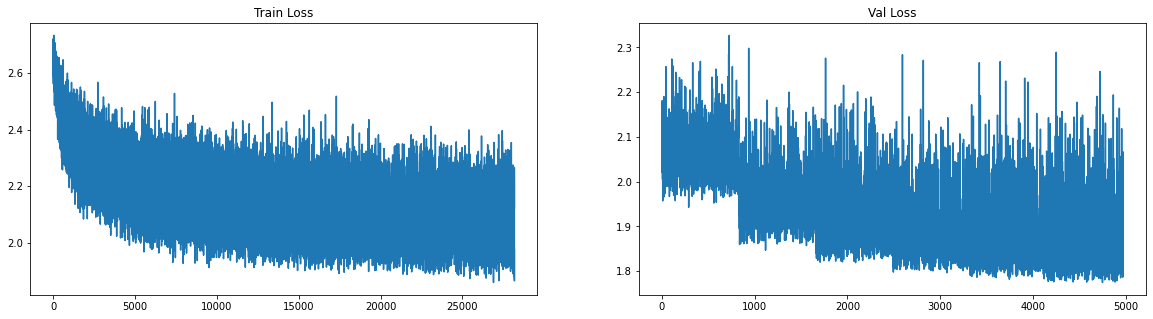

In [81]:
plot_losses(loss_set, val_loss_set)

Посмотрим на усредненный лосс:

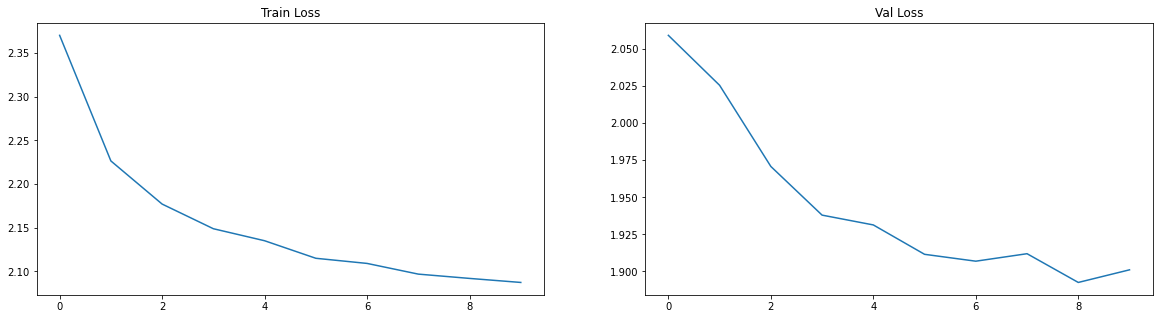

In [42]:
parts_to_div = 10

plot_losses(avg_loss(loss_set, parts_to_div), avg_loss(val_loss_set, parts_to_div))

Берем еще один Берт - cointegrated/rubert-tiny, отличающийся в разы от предыдущей версии по размеру, что скорее всего даст ухудшение в качестве, оценим какое и критичное ли. Т.к. в некоторых задачах стоит вопрос увеличения скорости инференса, и снижения характеристик сервера, на котором данная модель будет использоваться, то выбор модели порой является достаточно важным вопросом.

In [43]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [44]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_train)]
val_tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_val)]

  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

In [45]:
train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts)]

train_inputs = pad_sequences(train_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

train_masks = [[float(i>0) for i in seq] for seq in train_inputs]

validation_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(val_tokenized_texts)]

validation_inputs = pad_sequences(validation_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]

train_labels, validation_labels = np.array(y_train), np.array(y_val)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=8,
    sampler=torch.utils.data.RandomSampler(train_data)
)

validation_data = torch.utils.data.TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=8,
    sampler=torch.utils.data.SequentialSampler(validation_data)
)

  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

Класс модели, немного изменим его архитектуру, сделаем чуть проще, чем предыдущая модель - убрали 1 линейный слой, увеличили значение вероятности dropout, убрали функцию активации Relu:

In [62]:
class myBertModel2(torch.nn.Module):
    def __init__(self, hidden_neurons, num_labels):
        super(myBertModel2, self).__init__()
        self.num_labels = num_labels
        config = BertConfig.from_pretrained('cointegrated/rubert-tiny', num_labels=self.num_labels)
        self.model = BertModel.from_pretrained('cointegrated/rubert-tiny', config=config)
        self.hidden_neurons = hidden_neurons
        self.linear = torch.nn.Linear(config.hidden_size, int(self.hidden_neurons / 2))
        self.classifier = torch.nn.Linear(int(self.hidden_neurons / 2), self.num_labels)
        self.activation = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(.5)
        self.batchnorm = torch.nn.BatchNorm1d(int(self.hidden_neurons / 2))

    def forward(self, input_ids, attention_mask):
        bert_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = bert_output[0]
        pooled_output = seq_output.mean(axis=1)
        pooled_output = self.dropout(pooled_output)
        x1 = self.dropout(self.batchnorm(self.linear(pooled_output)))
        scores = self.dropout(self.classifier(x1))
        scores = self.activation(scores)
        return scores

my_model2 = myBertModel2(hidden_neurons=512, num_labels=num_labels)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Увеличим лосс на порядок, в остальном train loop остается без изменений:

In [63]:
n_epochs = 6
lr = 1e-4

model_1, loss_set_1, val_loss_set_1 = train_bert(model = my_model2, 
                                                 n_model = 1,
                                                 n_epochs = n_epochs, 
                                                 train_dataloader = train_dataloader, 
                                                 validation_dataloader = validation_dataloader,
                                                 lr = lr)

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.46      0.58      0.51      3310
              Мир       0.48      0.42      0.45      6964
   Интернет и СМИ       0.28      0.28      0.28      2246
           Россия       0.51      0.37      0.43      8179
  Наука и техника       0.36      0.35      0.36      2723
Силовые структуры       0.11      0.16      0.13      1023
      Бывший СССР       0.30      0.32      0.31      2705
         Культура       0.35      0.39      0.37      2705
        Экономика       0.44      0.39      0.41      4053
         Ценности       0.03      0.07      0.05       391
         Из жизни       0.15      0.18      0.16      1427
              Дом       0.12      0.17      0.14      1118
           Бизнес       0.03      0.07      0.05       368
      Путешествия       0.03      0.05      0.04       355

         accuracy                           0.36     37567
        macro avg       0.26      0.27      0.26     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.93      0.92      0.93       584
              Мир       0.58      0.89      0.70      1229
   Интернет и СМИ       0.63      0.42      0.50       397
           Россия       0.65      0.79      0.72      1443
  Наука и техника       0.80      0.59      0.68       481
Силовые структуры       0.75      0.03      0.06       180
      Бывший СССР       0.70      0.75      0.72       477
         Культура       0.77      0.80      0.78       478
        Экономика       0.68      0.70      0.69       715
         Ценности       0.00      0.00      0.00        69
         Из жизни       0.54      0.05      0.09       252
              Дом       0.08      0.01      0.01       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.00      0.00      0.00        63

         accuracy                           0.68      6630
        macro avg       0.51      0.42      0.42      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.41      0.88      0.56      3310
              Мир       0.46      0.55      0.50      6964
   Интернет и СМИ       0.34      0.37      0.36      2246
           Россия       0.52      0.46      0.48      8179
  Наука и техника       0.52      0.39      0.45      2723
Силовые структуры       0.25      0.21      0.23      1023
      Бывший СССР       0.53      0.39      0.45      2705
         Культура       0.62      0.45      0.52      2705
        Экономика       0.52      0.42      0.47      4053
         Ценности       0.35      0.18      0.24       391
         Из жизни       0.27      0.21      0.24      1427
              Дом       0.34      0.24      0.28      1118
           Бизнес       0.18      0.07      0.10       368
      Путешествия       0.29      0.10      0.14       355

         accuracy                           0.46     37567
        macro avg       0.40      0.35      0.36     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.95      0.91      0.93       584
              Мир       0.80      0.72      0.75      1229
   Интернет и СМИ       0.57      0.62      0.59       397
           Россия       0.70      0.82      0.75      1443
  Наука и техника       0.63      0.87      0.73       481
Силовые структуры       0.73      0.11      0.18       180
      Бывший СССР       0.73      0.80      0.77       477
         Культура       0.75      0.87      0.81       478
        Экономика       0.78      0.82      0.80       715
         Ценности       0.75      0.30      0.43        69
         Из жизни       0.72      0.33      0.46       252
              Дом       0.78      0.51      0.62       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.71      0.35      0.47        63

         accuracy                           0.74      6630
        macro avg       0.68      0.57      0.59      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.35      0.92      0.51      3310
              Мир       0.48      0.57      0.52      6964
   Интернет и СМИ       0.37      0.40      0.38      2246
           Россия       0.55      0.46      0.50      8179
  Наука и техника       0.61      0.45      0.52      2723
Силовые структуры       0.32      0.25      0.28      1023
      Бывший СССР       0.65      0.43      0.52      2705
         Культура       0.73      0.45      0.56      2705
        Экономика       0.63      0.43      0.51      4053
         Ценности       0.55      0.30      0.39       391
         Из жизни       0.41      0.29      0.34      1427
              Дом       0.58      0.36      0.44      1118
           Бизнес       0.20      0.10      0.13       368
      Путешествия       0.44      0.15      0.22       355

         accuracy                           0.49     37567
        macro avg       0.49      0.40      0.42     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.92      0.94       584
              Мир       0.75      0.82      0.78      1229
   Интернет и СМИ       0.74      0.38      0.50       397
           Россия       0.75      0.78      0.77      1443
  Наука и техника       0.68      0.83      0.75       481
Силовые структуры       0.66      0.18      0.29       180
      Бывший СССР       0.72      0.80      0.76       477
         Культура       0.83      0.81      0.82       478
        Экономика       0.73      0.85      0.79       715
         Ценности       0.40      0.81      0.54        69
         Из жизни       0.49      0.50      0.50       252
              Дом       0.76      0.59      0.66       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.73      0.17      0.28        63

         accuracy                           0.74      6630
        macro avg       0.66      0.60      0.60      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.34      0.93      0.50      3310
              Мир       0.48      0.60      0.53      6964
   Интернет и СМИ       0.40      0.45      0.42      2246
           Россия       0.59      0.47      0.52      8179
  Наука и техника       0.66      0.46      0.54      2723
Силовые структуры       0.38      0.30      0.34      1023
      Бывший СССР       0.68      0.43      0.53      2705
         Культура       0.77      0.44      0.56      2705
        Экономика       0.66      0.45      0.54      4053
         Ценности       0.67      0.39      0.50       391
         Из жизни       0.44      0.29      0.34      1427
              Дом       0.66      0.41      0.51      1118
           Бизнес       0.26      0.16      0.20       368
      Путешествия       0.52      0.18      0.27       355

         accuracy                           0.51     37567
        macro avg       0.54      0.43      0.45     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.94      0.94      0.94       584
              Мир       0.73      0.80      0.76      1229
   Интернет и СМИ       0.77      0.31      0.44       397
           Россия       0.78      0.73      0.76      1443
  Наука и техника       0.64      0.89      0.74       481
Силовые структуры       0.57      0.42      0.48       180
      Бывший СССР       0.80      0.75      0.78       477
         Культура       0.81      0.88      0.85       478
        Экономика       0.65      0.91      0.76       715
         Ценности       0.58      0.81      0.67        69
         Из жизни       0.59      0.35      0.44       252
              Дом       0.74      0.63      0.68       197
           Бизнес       0.00      0.00      0.00        65
      Путешествия       0.72      0.33      0.46        63

         accuracy                           0.74      6630
        macro avg       0.67      0.62      0.63      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.34      0.94      0.50      3310
              Мир       0.49      0.61      0.54      6964
   Интернет и СМИ       0.39      0.43      0.41      2246
           Россия       0.60      0.47      0.53      8179
  Наука и техника       0.69      0.46      0.55      2723
Силовые структуры       0.41      0.29      0.34      1023
      Бывший СССР       0.68      0.45      0.54      2705
         Культура       0.77      0.47      0.58      2705
        Экономика       0.67      0.43      0.53      4053
         Ценности       0.67      0.39      0.49       391
         Из жизни       0.49      0.32      0.39      1427
              Дом       0.70      0.39      0.50      1118
           Бизнес       0.35      0.18      0.24       368
      Путешествия       0.54      0.27      0.36       355

         accuracy                           0.51     37567
        macro avg       0.56      0.44      0.46     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.90      0.95      0.93       584
              Мир       0.76      0.78      0.77      1229
   Интернет и СМИ       0.64      0.64      0.64       397
           Россия       0.74      0.76      0.75      1443
  Наука и техника       0.83      0.76      0.79       481
Силовые структуры       0.63      0.37      0.47       180
      Бывший СССР       0.85      0.65      0.74       477
         Культура       0.74      0.90      0.82       478
        Экономика       0.70      0.87      0.78       715
         Ценности       0.87      0.68      0.76        69
         Из жизни       0.74      0.31      0.44       252
              Дом       0.65      0.69      0.67       197
           Бизнес       0.30      0.22      0.25        65
      Путешествия       0.50      0.60      0.55        63

         accuracy                           0.75      6630
        macro avg       0.70      0.66      0.67      

  0%|          | 0/4696 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.32      0.94      0.48      3310
              Мир       0.50      0.62      0.56      6964
   Интернет и СМИ       0.40      0.48      0.44      2246
           Россия       0.61      0.47      0.53      8179
  Наука и техника       0.71      0.46      0.56      2723
Силовые структуры       0.47      0.33      0.39      1023
      Бывший СССР       0.71      0.43      0.54      2705
         Культура       0.78      0.46      0.58      2705
        Экономика       0.72      0.44      0.55      4053
         Ценности       0.71      0.45      0.55       391
         Из жизни       0.51      0.36      0.42      1427
              Дом       0.72      0.41      0.52      1118
           Бизнес       0.28      0.16      0.20       368
      Путешествия       0.62      0.27      0.37       355

         accuracy                           0.52     37567
        macro avg       0.58      0.45      0.48     3

  0%|          | 0/829 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

            Спорт       0.96      0.92      0.94       584
              Мир       0.72      0.83      0.77      1229
   Интернет и СМИ       0.69      0.62      0.65       397
           Россия       0.77      0.78      0.78      1443
  Наука и техника       0.78      0.80      0.79       481
Силовые структуры       0.54      0.53      0.53       180
      Бывший СССР       0.71      0.89      0.79       477
         Культура       0.88      0.80      0.84       478
        Экономика       0.80      0.82      0.81       715
         Ценности       0.78      0.74      0.76        69
         Из жизни       0.75      0.21      0.32       252
              Дом       0.75      0.64      0.69       197
           Бизнес       0.42      0.22      0.29        65
      Путешествия       0.66      0.37      0.47        63

         accuracy                           0.77      6630
        macro avg       0.73      0.65      0.67      

Модель обучается достаточно быстро, в этом ее явный плюс, особенно по сравнению с той моделью, которую мы возьмем третьей.

Посмотрим на лоссы:

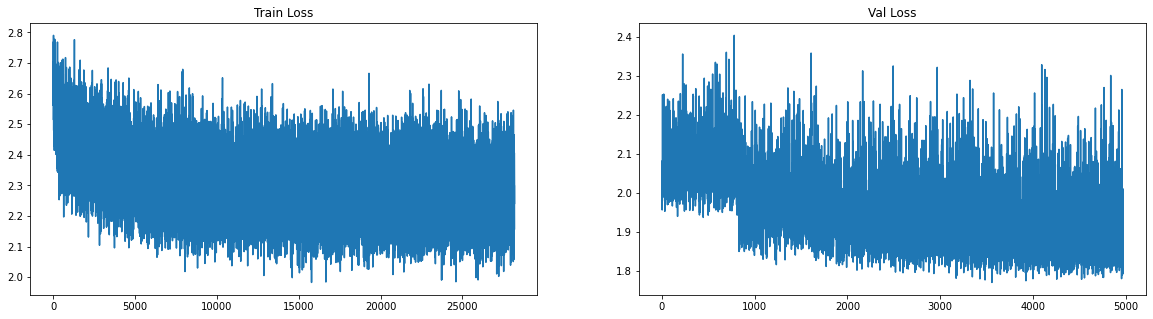

In [66]:
plot_losses(loss_set_1, val_loss_set_1)

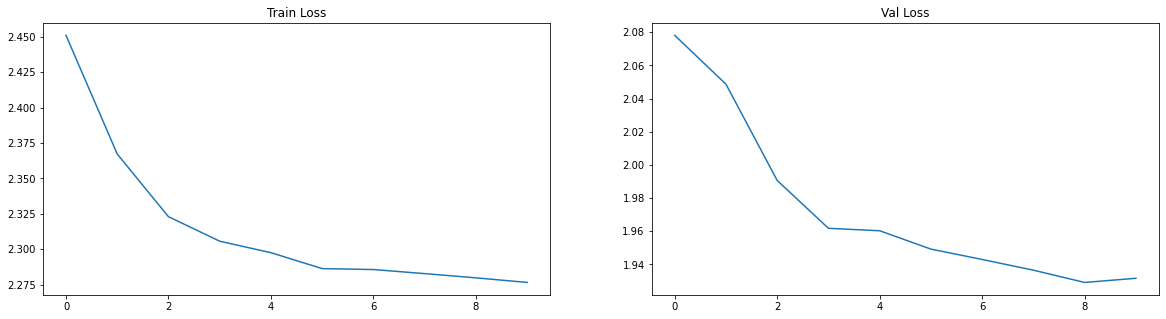

In [67]:
plot_losses(avg_loss(loss_set_1, parts_to_div), avg_loss(val_loss_set_1, parts_to_div))

Лосс падает хорошо, на валидации f1 = 0.76, но на трейне f1 гораздо ниже по сравнению с первой моделью.

P.S. пробовал дообучать с меньшим LR еще на шести эпохах, но существенного прироста в качестве не было.

Теперь возьмем T5, и будем решать задачу классификации, как задачу условной генерации. Модель самая тяжелая по сравнению с предыдущими, и по идее должна быть самой качественной.

In [13]:
from transformers import T5ForConditionalGeneration,T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained('sberbank-ai/ruT5-large')
tokenizer = T5Tokenizer.from_pretrained('sberbank-ai/ruT5-large')

Перепишем train loop и добавим некоторые вспомогательные функции:

In [14]:
def do_eval(evaluation_data, model):
    pred_labels, real_labels = [], []
    for text, real_label in evaluation_data:
        pred_label = generate_label(text, model)
        pred_labels.append(pred_label)
        real_labels.append(real_label)
    return real_labels, pred_labels

def generate_label(x, model, **kwargs):
    inputs = tokenizer(x, return_tensors='pt').to(model.device) 
    with torch.no_grad():
        hypotheses = model.generate(**inputs, **kwargs)
    label = tokenizer.decode(hypotheses[0], skip_special_tokens=True)
    return label
    
def train_t5(model, epochs, train_pairs, val_pairs, batch_size, report_steps, lr):
    optimizer = Adafactor(model.parameters(), lr=lr, relative_step=False)    
    model.to(device)
    
    losses = []
    val_losses = []

    for epoch in range(epochs):
        print('EPOCH', epoch)
        random.shuffle(train_pairs)
        model.train()
        optimizer.zero_grad()
        for i in tqdm(range(0, int(len(train_pairs) / batch_size))):
            batch = train_pairs[i * batch_size: (i + 1) * batch_size]

            x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True).to(model.device)
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True).to(model.device)
            y.input_ids[y.input_ids == 0] = -100

            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss

            loss = loss / 128
            loss.backward()

            if i % 128 == 0:
                optimizer.step()
                optimizer.zero_grad()

            losses.append(loss.item())

            if i % report_steps == 0 and i != 0:
                model.eval()
                for j in tqdm(range(0, int(len(val_pairs) / batch_size))):
                    batch = val_pairs[j * batch_size: (j + 1) * batch_size]
                    x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True).to(model.device)
                    y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True).to(model.device)
                    y.input_ids[y.input_ids == 0] = -100

                    with torch.no_grad():
                        loss = model(
                            input_ids=x.input_ids,
                            attention_mask=x.attention_mask,
                            labels=y.input_ids,
                            decoder_attention_mask=y.attention_mask,
                            return_dict=True
                        ).loss

                    val_losses.append(loss.item())
                
                real_train_labels, pred_train_labels = do_eval(train_pairs[-report_steps:], model)
                real_val_labels, pred_val_labels = do_eval(val_pairs, model)
                
                train_f1 = f1_score(real_train_labels, pred_train_labels, average='weighted')
                val_f1 = f1_score(real_val_labels, pred_val_labels, average='weighted')
                           
                print('Step {} ... Train f1: {:.2f} ... Val f1: {:.2f} ... Mean train loss: {:.4f} ... Mean val loss: {:.4f}'.format(i, train_f1, val_f1, np.mean(losses[-report_steps:]), np.mean(val_losses[-len(val_pairs):])))
                print()
                print(classification_report(real_train_labels, pred_train_labels)) 
                print()
                print(classification_report(real_val_labels, pred_val_labels)) 
                print()
                    
                model.train()
                
    return model, losses, val_losses

In [15]:
train_pairs = train.values.tolist()
val_pairs = val.values.tolist()

Теперь обучим модель, возьмем 1 эпоху, лосс Adafactor с LR = 1e-3, аккумуляцией градиента до 128 примеров в батче:

In [16]:
batch_size = 1
epochs = 1
lr = 1e-3
report_steps = 6000

t5_model_trained, train_loss, test_loss = train_t5(model, 
                                                   epochs, 
                                                   train_pairs, 
                                                   val_pairs, 
                                                   batch_size, 
                                                   report_steps, 
                                                   lr)

EPOCH 0


  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 6000 ... Train f1: 0.71 ... Val f1: 0.70 ... Mean train loss: 0.0081 ... Mean val loss: 0.3799

                   precision    recall  f1-score   support

                        0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00        61
      Бывший СССР       0.93      0.48      0.63       422
              Дом       0.82      0.55      0.66       172
         Из жизни       0.73      0.27      0.39       234
   Интернет и СМИ       0.66      0.66      0.66       357
         Культура       0.83      0.91      0.87       431
              Мир       0.78      0.79      0.79      1113
  Наука и техника       0.75      0.84      0.79       440
      Путешествия       0.00      0.00      0.00        51
           Россия       0.78      0.71      0.75      1270
Силовые структуры       0.50      0.07      0.12       142
            Спорт       0.95      0.96      0.96       549
         Ценности       0.90      0.40      0.55        65
        Эконо

/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/6630 [00:00<?, ?it/s]

Step 12000 ... Train f1: 0.75 ... Val f1: 0.74 ... Mean train loss: 0.0027 ... Mean val loss: 0.3133

                   precision    recall  f1-score   support

                        0.00      0.00      0.00         0
           Бизнес       0.47      0.11      0.18        61
      Бывший СССР       0.80      0.86      0.83       422
              Дом       0.85      0.71      0.77       172
         Из жизни       0.61      0.46      0.52       234
   Интернет и СМИ       0.90      0.41      0.56       357
         Культура       0.86      0.88      0.87       431
              Мир       0.89      0.67      0.77      1113
  Наука и техника       0.73      0.91      0.81       440
      Путешествия       0.67      0.24      0.35        51
           Россия       0.66      0.92      0.77      1270
Силовые структуры       0.57      0.06      0.10       142
            Спорт       0.93      0.98      0.95       549
         Ценности       0.77      0.66      0.71        65
        Экон

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 18000 ... Train f1: 0.74 ... Val f1: 0.73 ... Mean train loss: 0.0024 ... Mean val loss: 0.2919

                   precision    recall  f1-score   support

                        0.00      0.00      0.00         0
           Бизнес       0.25      0.08      0.12        61
      Бывший СССР       0.84      0.86      0.85       422
              Дом       0.79      0.74      0.77       172
         Из жизни       0.72      0.23      0.35       234
   Интернет и СМИ       0.89      0.33      0.48       357
         Культура       0.78      0.93      0.84       431
              Мир       0.81      0.74      0.77      1113
  Наука и техника       0.88      0.72      0.79       440
      Путешествия       1.00      0.06      0.11        51
           Россия       0.62      0.94      0.74      1270
Силовые структуры       0.50      0.16      0.24       142
            Спорт       0.93      0.96      0.95       549
         Ценности       0.68      0.83      0.74        65
        Экон

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 24000 ... Train f1: 0.79 ... Val f1: 0.79 ... Mean train loss: 0.0022 ... Mean val loss: 0.2262

                   precision    recall  f1-score   support

           Бизнес       0.47      0.46      0.46        61
      Бывший СССР       0.80      0.90      0.85       422
              Дом       0.83      0.81      0.82       172
         Из жизни       0.67      0.44      0.53       234
   Интернет и СМИ       0.86      0.45      0.59       357
         Культура       0.89      0.85      0.87       431
              Мир       0.75      0.89      0.81      1113
  Наука и техника       0.86      0.81      0.83       440
      Путешествия       0.82      0.45      0.58        51
           Россия       0.73      0.88      0.80      1270
Силовые структуры       0.70      0.40      0.51       142
            Спорт       0.99      0.89      0.94       549
         Ценности       0.80      0.74      0.77        65
        Экономика       0.88      0.77      0.82       693

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 30000 ... Train f1: 0.81 ... Val f1: 0.80 ... Mean train loss: 0.0020 ... Mean val loss: 0.2148

                   precision    recall  f1-score   support

           Бизнес       0.67      0.16      0.26        61
      Бывший СССР       0.89      0.80      0.84       422
              Дом       0.87      0.77      0.82       172
         Из жизни       0.50      0.80      0.62       234
   Интернет и СМИ       0.82      0.59      0.69       357
         Культура       0.86      0.89      0.88       431
              Мир       0.89      0.77      0.83      1113
  Наука и техника       0.83      0.87      0.85       440
      Путешествия       0.57      0.65      0.61        51
           Россия       0.76      0.90      0.83      1270
Силовые структуры       0.74      0.12      0.21       142
            Спорт       0.94      0.98      0.96       549
         Ценности       0.81      0.74      0.77        65
        Экономика       0.82      0.88      0.85       693

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 36000 ... Train f1: 0.83 ... Val f1: 0.79 ... Mean train loss: 0.0019 ... Mean val loss: 0.2415

                   precision    recall  f1-score   support

           Бизнес       0.76      0.31      0.44        61
      Бывший СССР       0.91      0.85      0.88       422
              Дом       0.93      0.89      0.91       172
         Из жизни       0.64      0.73      0.68       234
   Интернет и СМИ       0.89      0.63      0.74       357
         Культура       0.84      0.97      0.90       431
              Мир       0.95      0.66      0.78      1113
  Наука и техника       0.90      0.84      0.87       440
      Путешествия       0.74      0.57      0.64        51
           Россия       0.75      0.93      0.83      1270
Силовые структуры       0.71      0.50      0.59       142
            Спорт       0.94      0.99      0.97       549
         Ценности       0.79      0.88      0.83        65
        Экономика       0.80      0.95      0.87       693

         ac

В принципе неплохо, сравнимо с бертом по качеству, лосс также падает.

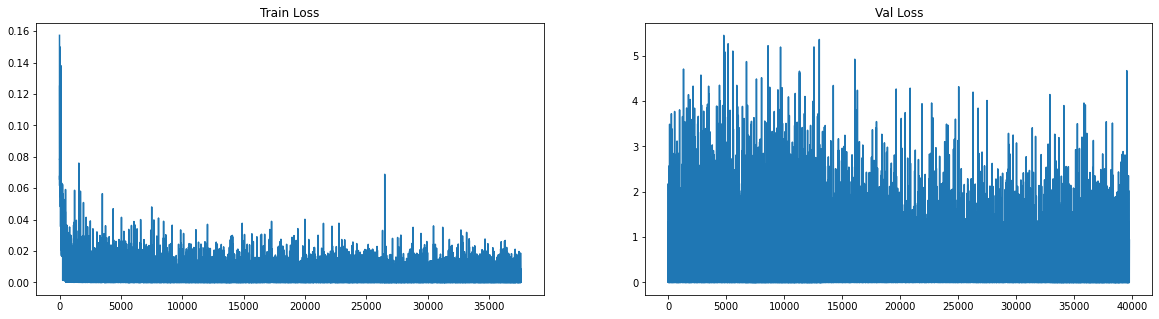

In [19]:
plot_losses(train_loss, test_loss)

Попробуем понизить LR, и обучим модель еще одну эпоху:

In [20]:
lr = 1e-4

t5_model_trained_1, train_loss_1, test_loss_1 = train_t5(t5_model_trained, 
                                                         epochs, 
                                                         train_pairs, 
                                                         val_pairs, 
                                                         batch_size, 
                                                         report_steps, 
                                                         lr)

EPOCH 0


  0%|          | 0/37567 [00:00<?, ?it/s]

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 6000 ... Train f1: 0.85 ... Val f1: 0.83 ... Mean train loss: 0.0014 ... Mean val loss: 0.1821

                   precision    recall  f1-score   support

           Бизнес       0.58      0.59      0.59        61
      Бывший СССР       0.89      0.86      0.87       430
              Дом       0.92      0.91      0.91       170
         Из жизни       0.79      0.68      0.73       233
   Интернет и СМИ       0.87      0.73      0.80       371
         Культура       0.90      0.94      0.92       443
              Мир       0.82      0.87      0.84      1066
  Наука и техника       0.86      0.83      0.84       419
      Путешествия       0.92      0.78      0.84        58
           Россия       0.84      0.86      0.85      1357
Силовые структуры       0.71      0.64      0.67       172
            Спорт       0.96      0.99      0.97       493
         Ценности       0.87      0.88      0.87        67
        Экономика       0.87      0.89      0.88       660

         acc

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 12000 ... Train f1: 0.86 ... Val f1: 0.83 ... Mean train loss: 0.0014 ... Mean val loss: 0.1816

                   precision    recall  f1-score   support

           Бизнес       0.56      0.61      0.58        61
      Бывший СССР       0.90      0.87      0.89       430
              Дом       0.93      0.90      0.92       170
         Из жизни       0.78      0.70      0.73       233
   Интернет и СМИ       0.86      0.77      0.81       371
         Культура       0.92      0.93      0.93       443
              Мир       0.82      0.88      0.85      1066
  Наука и техника       0.87      0.83      0.85       419
      Путешествия       0.91      0.84      0.88        58
           Россия       0.86      0.86      0.86      1357
Силовые структуры       0.65      0.70      0.67       172
            Спорт       0.97      0.98      0.98       493
         Ценности       0.88      0.90      0.89        67
        Экономика       0.88      0.88      0.88       660

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 18000 ... Train f1: 0.86 ... Val f1: 0.84 ... Mean train loss: 0.0013 ... Mean val loss: 0.1798

                   precision    recall  f1-score   support

           Бизнес       0.51      0.66      0.58        61
      Бывший СССР       0.91      0.87      0.89       430
              Дом       0.97      0.88      0.92       170
         Из жизни       0.85      0.63      0.72       233
   Интернет и СМИ       0.84      0.77      0.80       371
         Культура       0.90      0.96      0.93       443
              Мир       0.85      0.85      0.85      1066
  Наука и техника       0.86      0.85      0.85       419
      Путешествия       0.89      0.81      0.85        58
           Россия       0.84      0.89      0.86      1357
Силовые структуры       0.73      0.63      0.68       172
            Спорт       0.97      0.99      0.98       493
         Ценности       0.87      0.82      0.85        67
        Экономика       0.86      0.90      0.88       660

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 24000 ... Train f1: 0.86 ... Val f1: 0.83 ... Mean train loss: 0.0013 ... Mean val loss: 0.1788

                   precision    recall  f1-score   support

           Бизнес       0.55      0.59      0.57        61
      Бывший СССР       0.92      0.85      0.89       430
              Дом       0.97      0.87      0.92       170
         Из жизни       0.86      0.58      0.69       233
   Интернет и СМИ       0.84      0.75      0.79       371
         Культура       0.91      0.94      0.93       443
              Мир       0.82      0.87      0.85      1066
  Наука и техника       0.87      0.83      0.85       419
      Путешествия       0.89      0.81      0.85        58
           Россия       0.82      0.89      0.85      1357
Силовые структуры       0.70      0.65      0.67       172
            Спорт       0.97      0.99      0.98       493
         Ценности       0.89      0.82      0.85        67
        Экономика       0.88      0.88      0.88       660

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 30000 ... Train f1: 0.86 ... Val f1: 0.84 ... Mean train loss: 0.0013 ... Mean val loss: 0.1765

                   precision    recall  f1-score   support

           Бизнес       0.50      0.74      0.60        61
      Бывший СССР       0.93      0.83      0.88       430
              Дом       0.97      0.87      0.92       170
         Из жизни       0.83      0.64      0.72       233
   Интернет и СМИ       0.84      0.78      0.81       371
         Культура       0.92      0.94      0.93       443
              Мир       0.83      0.86      0.85      1066
  Наука и техника       0.87      0.84      0.85       419
      Путешествия       0.89      0.83      0.86        58
           Россия       0.83      0.89      0.86      1357
Силовые структуры       0.74      0.62      0.67       172
            Спорт       0.97      0.99      0.98       493
         Ценности       0.90      0.82      0.86        67
        Экономика       0.87      0.88      0.88       660

         ac

  0%|          | 0/6630 [00:00<?, ?it/s]

Step 36000 ... Train f1: 0.88 ... Val f1: 0.84 ... Mean train loss: 0.0013 ... Mean val loss: 0.1770

                   precision    recall  f1-score   support

           Бизнес       0.54      0.74      0.62        61
      Бывший СССР       0.90      0.90      0.90       430
              Дом       0.98      0.92      0.95       170
         Из жизни       0.84      0.70      0.76       233
   Интернет и СМИ       0.84      0.82      0.83       371
         Культура       0.93      0.95      0.94       443
              Мир       0.86      0.86      0.86      1066
  Наука и техника       0.88      0.82      0.85       419
      Путешествия       0.91      0.83      0.86        58
           Россия       0.85      0.91      0.88      1357
Силовые структуры       0.75      0.63      0.69       172
            Спорт       0.98      0.99      0.98       493
         Ценности       0.87      0.88      0.87        67
        Экономика       0.90      0.88      0.89       660

         ac

Неудивительно модель показала наилучшее качество по сравнению с предыдущими, 0.84 f1 на валидации.

Общий лосс за две эпохи:

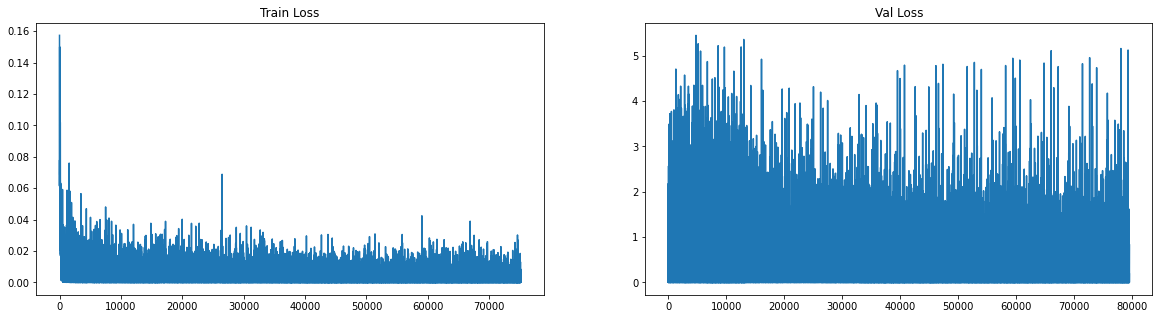

In [22]:
plot_losses(train_loss + train_loss_1, test_loss + test_loss_1)

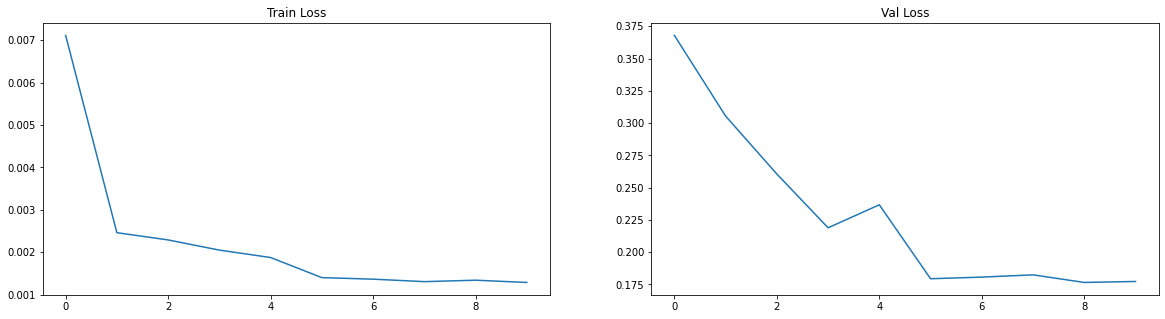

In [69]:
plot_losses(avg_loss(train_loss + train_loss_1, parts_to_div), avg_loss(test_loss + test_loss_1, parts_to_div))

## Задание 2

1. Roberta описана в статье https://arxiv.org/pdf/1907.11692.pdf (RoBERTa: A Robustly Optimized BERT Pretraining Approach)

Отличается от Bert следующим:
 1) Токенизатор BPE, вместо Wordpiece;<br>
 2) Улучшенные гиперпаметры при обучении: увеличенный batch size до 8k примеров в батче, увеличено число шагов при предобучении (warmup steps), увеличено максимальное значение LR;<br>
 3) Убрали при обучении предсказание следующего предложения после текущего - Next Sentence Prediction;<br>
 4) Применение динамических масок слов при обучении, в отличие от Bert-а маски которого были статическими. При обучении Roberta одно и тоже предложение модели показывалось 4 раза;<br>
 5) Увеличено число обучающих данных 13Gb против 160Gb - были добавлены тексты книг и англоязычной Википедии, Common Crawl News, OpenWebText.<br><br>

2. T5 (https://arxiv.org/pdf/1910.10683.pdf) представляет собой модель с архитектурой энкодер-декодер, в отличие от Bert и Roberta, архитектура которых представляет только энкодер. <br>
Задачи, на которых обучалась T5 представляют собой формат виде text-to-text, т.е. любая NLP задача решается с помощью метода перевода одной текстовой последовательности в другую.<br>
Модель обучалась на нескольких типах задач: unsupervised denoising training, supervised training.<br>
1 тип решает задачу предсказания токенов \<extra_id_0> ... \<extra_id_99> в тексте. Например, "Собака \<extra_id_0>" - > "\<extra_id_0> лает.".<br>
2 тип с помощью префиксов с описанием задания, например, 'Summarize: ' или 'Translate English to Spain: '.<br>
Эти типы отличаются от тех, что были использованы при обучении Bert или Roberta.<br>
T5 обучалась с Adafactor loss, в отличие от Adam у Bert.